In [8]:
# Build a recommendation engine that recommends movies to users.
# Item Based Collaborative Filter recommendation system
library(recommenderlab)
library(ggplot2)                       
library(data.table)
library(reshape2)

In [9]:
# Retrieve and display data
movie_data <- read.csv("movies.csv",stringsAsFactors=FALSE)
rating_data <- read.csv("ratings.csv")
str(movie_data)

'data.frame':	10329 obs. of  3 variables:
 $ movieId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ title  : chr  "Toy Story (1995)" "Jumanji (1995)" "Grumpier Old Men (1995)" "Waiting to Exhale (1995)" ...
 $ genres : chr  "Adventure|Animation|Children|Comedy|Fantasy" "Adventure|Children|Fantasy" "Comedy|Romance" "Comedy|Drama|Romance" ...


In [10]:
# Overview the summary 
summary(movie_data)
head(movie_data)
summary(rating_data)
head(rating_data)

    movieId          title              genres         
 Min.   :     1   Length:10329       Length:10329      
 1st Qu.:  3240   Class :character   Class :character  
 Median :  7088   Mode  :character   Mode  :character  
 Mean   : 31924                                        
 3rd Qu.: 59900                                        
 Max.   :149532                                        

,movieId,title,genres
,<int>,<chr>,<chr>
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
6,6,Heat (1995),Action|Crime|Thriller


     userId         movieId           rating        timestamp        
 Min.   :  1.0   Min.   :     1   Min.   :0.500   Min.   :8.286e+08  
 1st Qu.:192.0   1st Qu.:  1073   1st Qu.:3.000   1st Qu.:9.711e+08  
 Median :383.0   Median :  2497   Median :3.500   Median :1.115e+09  
 Mean   :364.9   Mean   : 13381   Mean   :3.517   Mean   :1.130e+09  
 3rd Qu.:557.0   3rd Qu.:  5991   3rd Qu.:4.000   3rd Qu.:1.275e+09  
 Max.   :668.0   Max.   :149532   Max.   :5.000   Max.   :1.452e+09  

,userId,movieId,rating,timestamp
,<int>,<int>,<dbl>,<int>
1,1,16,4.0,1217897793
2,1,24,1.5,1217895807
3,1,32,4.0,1217896246
4,1,47,4.0,1217896556
5,1,50,4.0,1217896523
6,1,110,4.0,1217896150


In [11]:
# Data pre-processing
# Creating a one-hot encoding to create a matrix that comprises of corresponding genres for each of the films.
movie_genre <- as.data.frame(movie_data$genres, stringsAsFactors=FALSE)
library(data.table)
movie_genre2 <- as.data.frame(tstrsplit(movie_genre[,1], '[|]', 
                                        type.convert=TRUE), 
                              stringsAsFactors=FALSE) 
colnames(movie_genre2) <- c(1:10)
list_genre <- c("Action", "Adventure", "Animation", "Children", 
                "Comedy", "Crime","Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery","Romance",
                "Sci-Fi", "Thriller", "War", "Western")
genre_mat1 <- matrix(0,10330,18)
genre_mat1[1,] <- list_genre
colnames(genre_mat1) <- list_genre
for (index in 1:nrow(movie_genre2)) {
  for (col in 1:ncol(movie_genre2)) {
    gen_col = which(genre_mat1[1,] == movie_genre2[index,col]) 
    genre_mat1[index+1,gen_col] <- 1
  }
}
genre_mat2 <- as.data.frame(genre_mat1[-1,], stringsAsFactors=FALSE) #remove first row, which was the genre list
for (col in 1:ncol(genre_mat2)) {
  genre_mat2[,col] <- as.integer(genre_mat2[,col]) #convert from characters to integers
} 
str(genre_mat2)

'data.frame':	10329 obs. of  18 variables:
 $ Action     : int  0 0 0 0 0 1 0 0 1 1 ...
 $ Adventure  : int  1 1 0 0 0 0 0 1 0 1 ...
 $ Animation  : int  1 0 0 0 0 0 0 0 0 0 ...
 $ Children   : int  1 1 0 0 0 0 0 1 0 0 ...
 $ Comedy     : int  1 0 1 1 1 0 1 0 0 0 ...
 $ Crime      : int  0 0 0 0 0 1 0 0 0 0 ...
 $ Documentary: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Drama      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ Fantasy    : int  1 1 0 0 0 0 0 0 0 0 ...
 $ Film-Noir  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Horror     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Musical    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Mystery    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Romance    : int  0 0 1 1 0 0 1 0 0 0 ...
 $ Sci-Fi     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Thriller   : int  0 0 0 0 0 1 0 0 0 1 ...
 $ War        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Western    : int  0 0 0 0 0 0 0 0 0 0 ...


In [12]:
# Creating a ‘search matrix’ - searching films by specifying the genre
SearchMatrix <- cbind(movie_data[,1:2], genre_mat2[])
head(SearchMatrix)
ratingMatrix <- dcast(rating_data, userId~movieId, value.var = "rating", na.rm=FALSE)
ratingMatrix <- as.matrix(ratingMatrix[,-1]) #remove userIds

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
5,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,Heat (1995),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [13]:
#Convert rating matrix into a recommenderlab sparse matrix
ratingMatrix <- as(ratingMatrix, "realRatingMatrix")
ratingMatrix

668 x 10325 rating matrix of class 'realRatingMatrix' with 105339 ratings.

In [14]:
# Overview some important parameters for building recommendation systems for movies
recommendation_model <- recommenderRegistry$get_entries(dataType = "realRatingMatrix")
names(recommendation_model)
lapply(recommendation_model, "[[", "description")

[1] "HYBRID_realRatingMatrix"       "ALS_realRatingMatrix"         
 [3] "ALS_implicit_realRatingMatrix" "IBCF_realRatingMatrix"        
 [5] "LIBMF_realRatingMatrix"        "POPULAR_realRatingMatrix"     
 [7] "RANDOM_realRatingMatrix"       "RERECOMMEND_realRatingMatrix" 
 [9] "SVD_realRatingMatrix"          "SVDF_realRatingMatrix"        
[11] "UBCF_realRatingMatrix"

$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF_realRatingMatrix
[1] "Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html)."

$UBCF_realRatingMatrix
[1] "Recommender based on user-based collaborative filtering."

In [15]:
# Implementing a single model in the R project – Item Based Collaborative Filtering
recommendation_model$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

,1,2,3,4
1,0.0000000,0.9760860,0.9641723,0.9914398
2,0.9760860,0.0000000,0.9925732,0.9374253
3,0.9641723,0.9925732,0.0000000,0.9888968
4,0.9914398,0.9374253,0.9888968,0.0000000


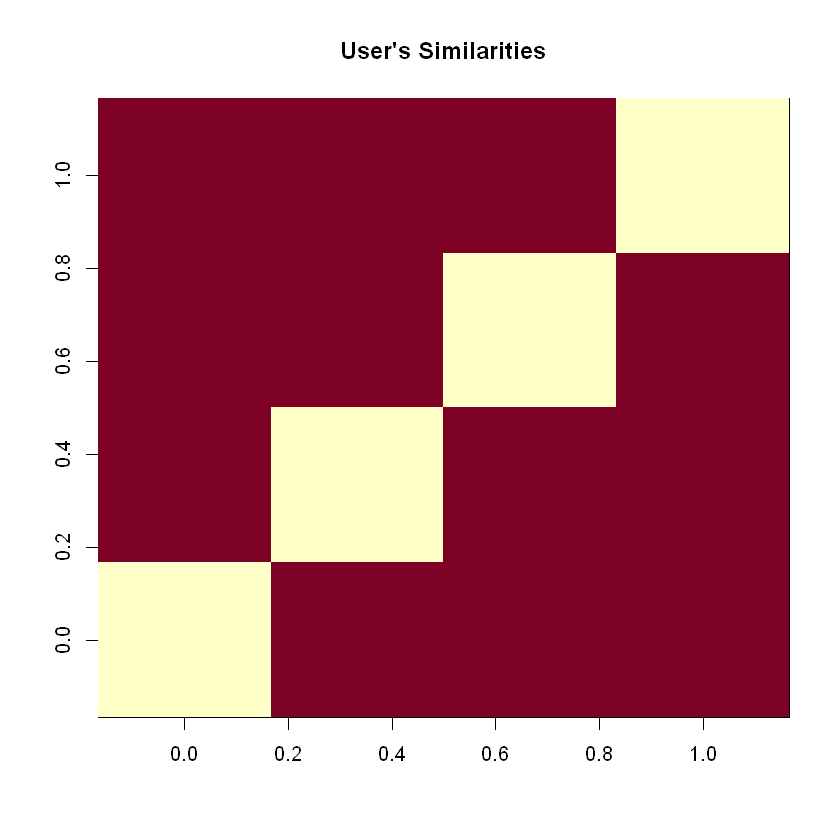

In [16]:
# Collaborative Filtering involves suggesting movies to the users that are based on collecting preferences from many other users.
# With the help of recommenderlab, we can compute similarities between users
similarity_mat <- similarity(ratingMatrix[1:4, ],
                             method = "cosine",
                             which = "users")
as.matrix(similarity_mat)
image(as.matrix(similarity_mat), main = "User's Similarities")

,1,2,3,4
1,0.0000000,0.9669732,0.9559341,0.9101276
2,0.9669732,0.0000000,0.9658757,0.9412416
3,0.9559341,0.9658757,0.0000000,0.9864877
4,0.9101276,0.9412416,0.9864877,0.0000000


[1] 0.0 5.0 4.0 3.0 4.5 1.5 2.0 3.5 1.0 2.5 0.5

rating_values
      0     0.5       1     1.5       2     2.5       3     3.5       4     4.5 
6791761    1198    3258    1567    7943    5484   21729   12237   28880    8187 
      5 
  14856 

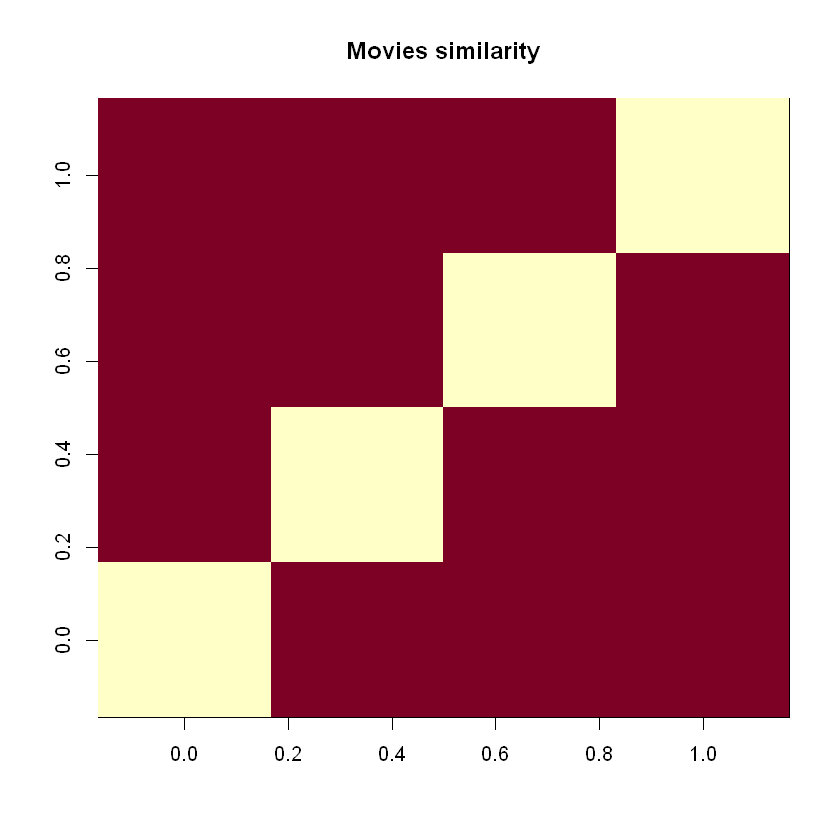

In [17]:
# Portray the similarity that is shared between the films
movie_similarity <- similarity(ratingMatrix[, 1:4], method =
                                 "cosine", which = "items")
as.matrix(movie_similarity)
image(as.matrix(movie_similarity), main = "Movies similarity")
rating_values <- as.vector(ratingMatrix@data)
unique(rating_values) # extracting unique ratings
Table_of_Ratings <- table(rating_values) # creating a count of movie ratings
Table_of_Ratings

In [18]:
# Most viewed movies visualization
library(ggplot2)
movie_views <- colCounts(ratingMatrix) # count views for each movie
table_views <- data.frame(movie = names(movie_views),
                          views = movie_views) # create dataframe of views
table_views <- table_views[order(table_views$views,
                                 decreasing = TRUE), ] # sort by number of views
table_views$title <- NA
for (index in 1:10325){
  table_views[index,3] <- as.character(subset(movie_data,
                                              movie_data$movieId == table_views[index,1])$title)
}
table_views[1:6,]

,movie,views,title
,<chr>,<int>,<chr>
296,296,325,Pulp Fiction (1994)
356,356,311,Forrest Gump (1994)
318,318,308,"Shawshank Redemption, The (1994)"
480,480,294,Jurassic Park (1993)
593,593,290,"Silence of the Lambs, The (1991)"
260,260,273,Star Wars: Episode IV - A New Hope (1977)


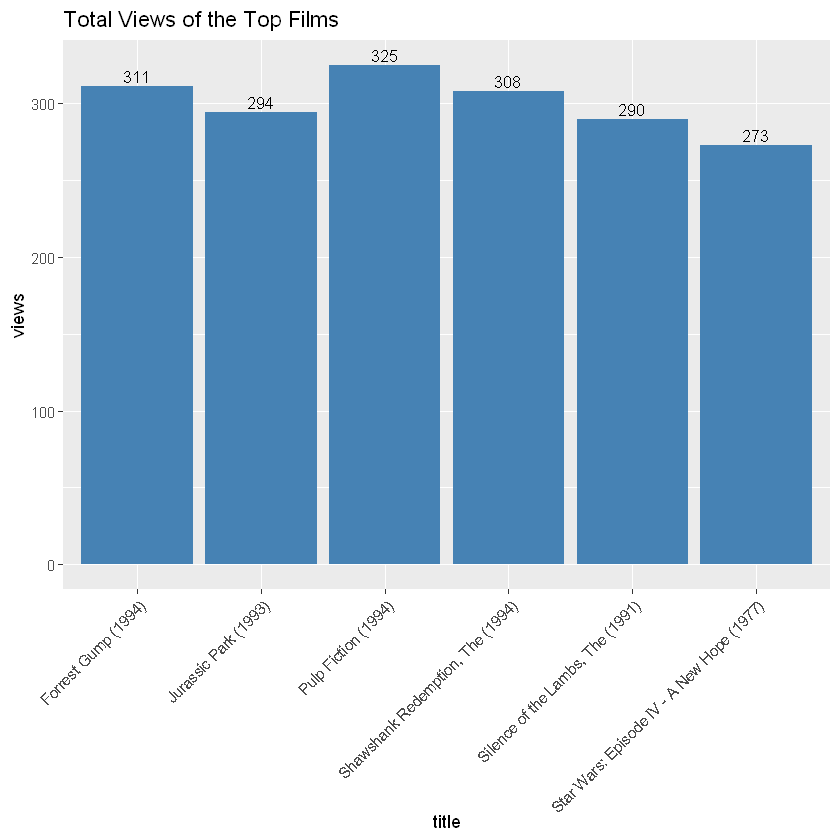

In [19]:
# Visualize a bar plot for the total number of views of the top films
ggplot(table_views[1:6, ], aes(x = title, y = views)) +
  geom_bar(stat="identity", fill = 'steelblue') +
  geom_text(aes(label=views), vjust=-0.3, size=3.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Total Views of the Top Films")

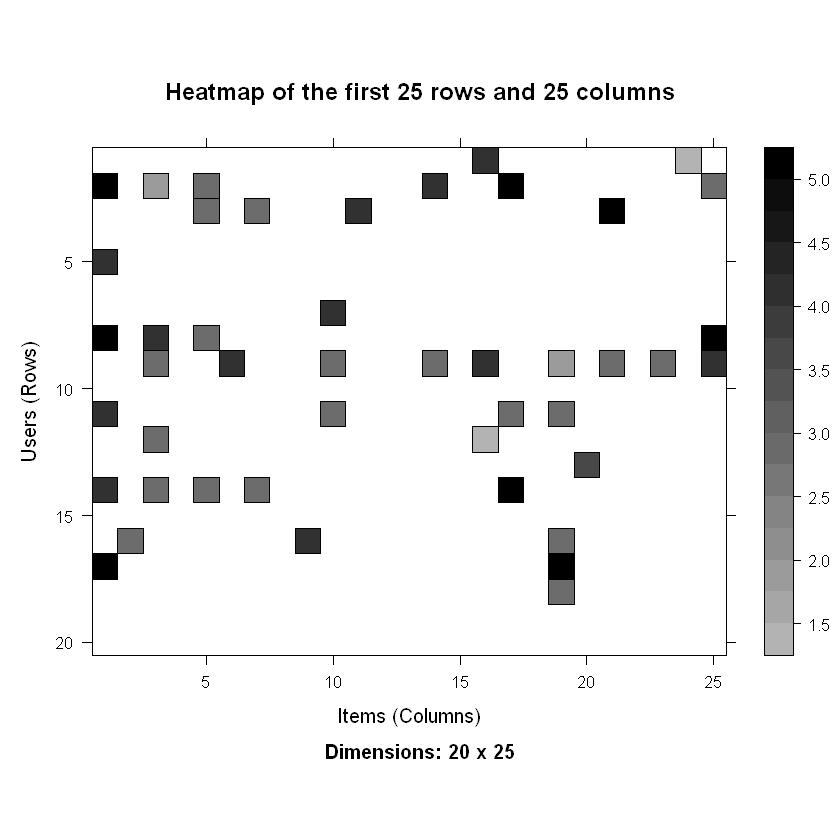

In [20]:
# Heatmap of Movie Ratings
# Visualize a heatmap of the movie ratings
image(ratingMatrix[1:20, 1:25], axes = FALSE, main = "Heatmap of the first 25 rows and 25 columns")

In [21]:
# Data Preparation
movie_ratings <- ratingMatrix[rowCounts(ratingMatrix) > 50,
                              colCounts(ratingMatrix) > 50]
movie_ratings

420 x 447 rating matrix of class 'realRatingMatrix' with 38341 ratings.

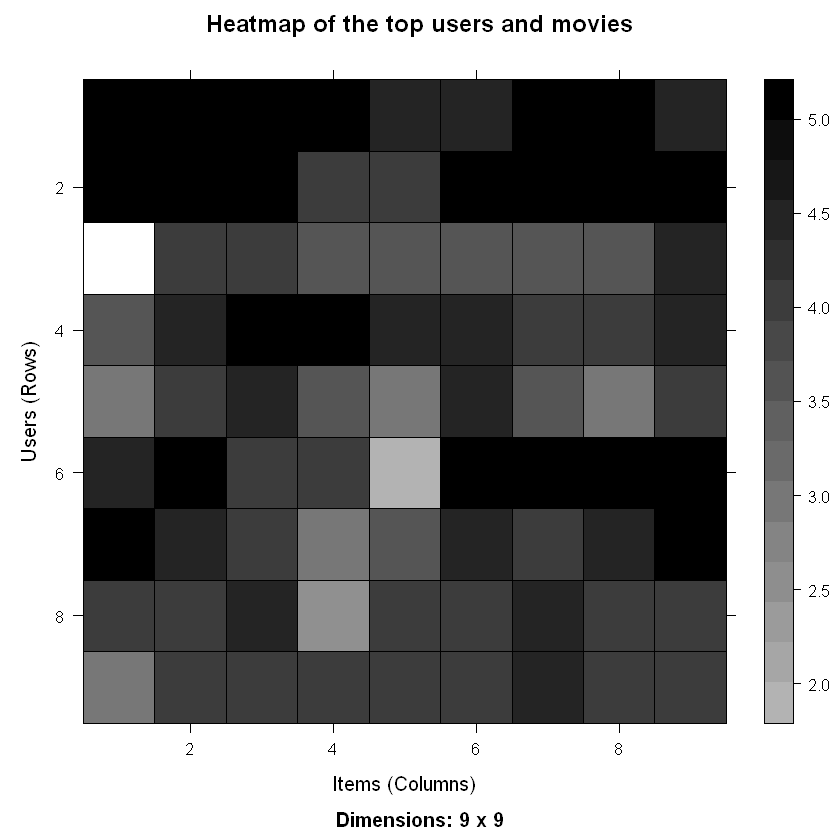

In [22]:
# describing matrix of relevant users
minimum_movies<- quantile(rowCounts(movie_ratings), 0.98)
minimum_users <- quantile(colCounts(movie_ratings), 0.98)
image(movie_ratings[rowCounts(movie_ratings) > minimum_movies,
                    colCounts(movie_ratings) > minimum_users],
      main = "Heatmap of the top users and movies")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



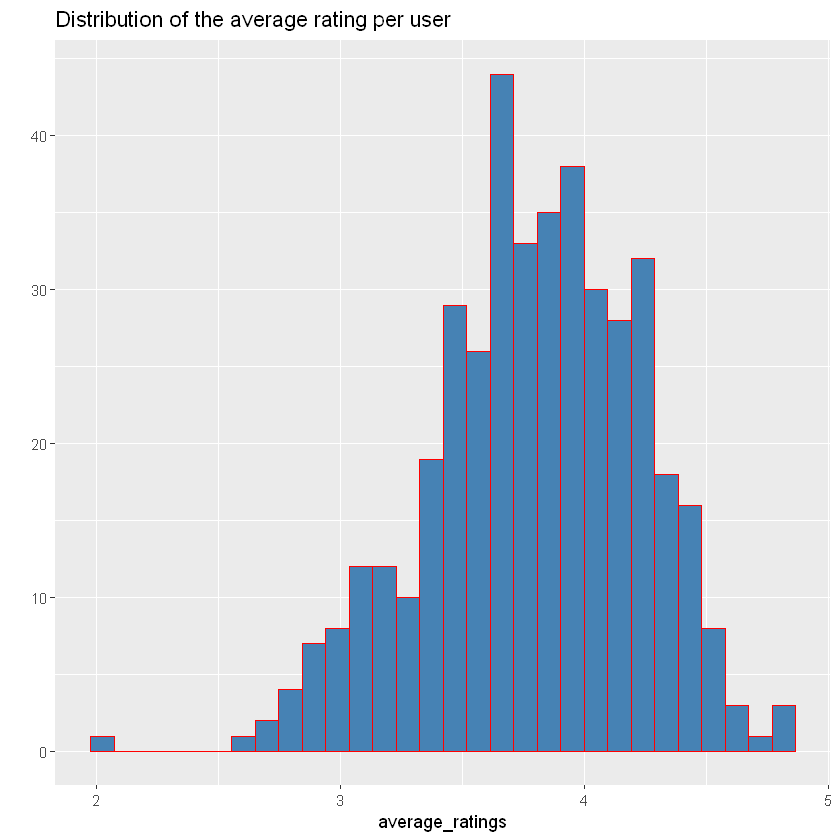

In [23]:
# Visualizing the distribution of the average ratings per user
average_ratings <- rowMeans(movie_ratings)
qplot(average_ratings, fill=I("steelblue"), col=I("red")) +
  ggtitle("Distribution of the average rating per user")

[1] 0

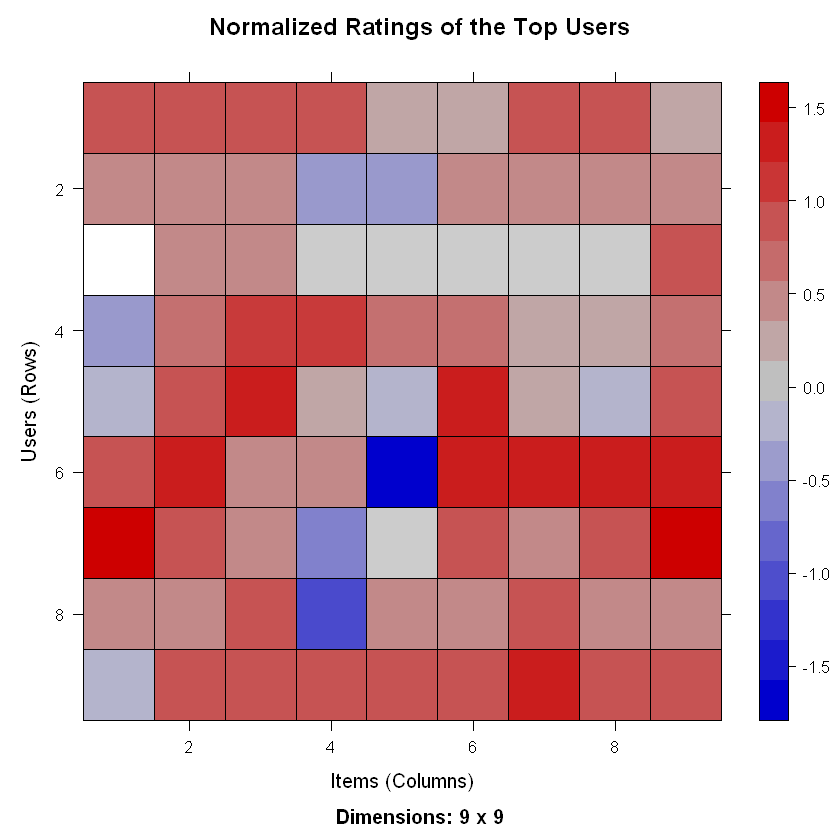

In [24]:
# Data Normalization
normalized_ratings <- normalize(movie_ratings)
sum(rowMeans(normalized_ratings) > 0.00001)
image(normalized_ratings[rowCounts(normalized_ratings) > minimum_movies,
                         colCounts(normalized_ratings) > minimum_users],
      main = "Normalized Ratings of the Top Users")

In [25]:
# Data Binarization
binary_minimum_movies <- quantile(rowCounts(movie_ratings), 0.95)
binary_minimum_users <- quantile(colCounts(movie_ratings), 0.95)

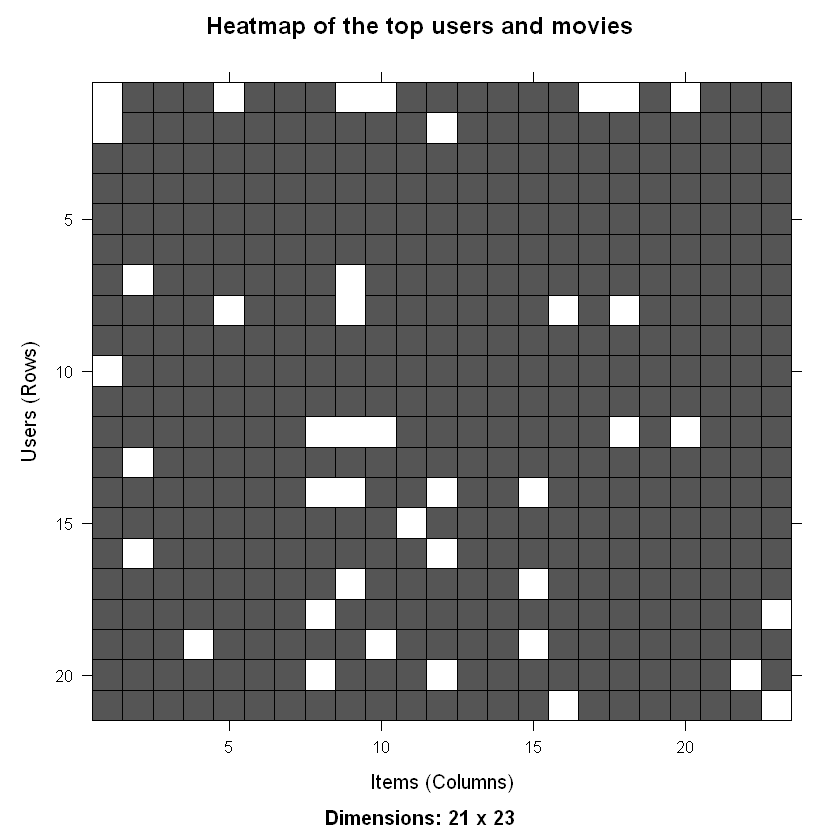

In [26]:
#movies_watched <- binarize(movie_ratings, minRating = 1)
good_rated_films <- binarize(movie_ratings, minRating = 3)
image(good_rated_films[rowCounts(movie_ratings) > binary_minimum_movies,
                       colCounts(movie_ratings) > binary_minimum_users],
      main = "Heatmap of the top users and movies")

In [27]:
# Collaborative Filtering System
# Splitting the dataset into 80% training set and 20% test set
sampled_data<- sample(x = c(TRUE, FALSE),
                      size = nrow(movie_ratings),
                      replace = TRUE,
                      prob = c(0.8, 0.2))
training_data <- movie_ratings[sampled_data, ]
testing_data <- movie_ratings[!sampled_data, ]

In [28]:
# Building the Recommendation System
recommendation_system <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommendation_system$IBCF_realRatingMatrix$parameters
recommen_model <- Recommender(data = training_data,
                              method = "IBCF",
                              parameter = list(k = 30))
recommen_model
class(recommen_model)

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

Recommender of type 'IBCF' for 'realRatingMatrix' 
learned using 341 users.

[1] "Recommender"
attr(,"package")
[1] "recommenderlab"

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] 447 447

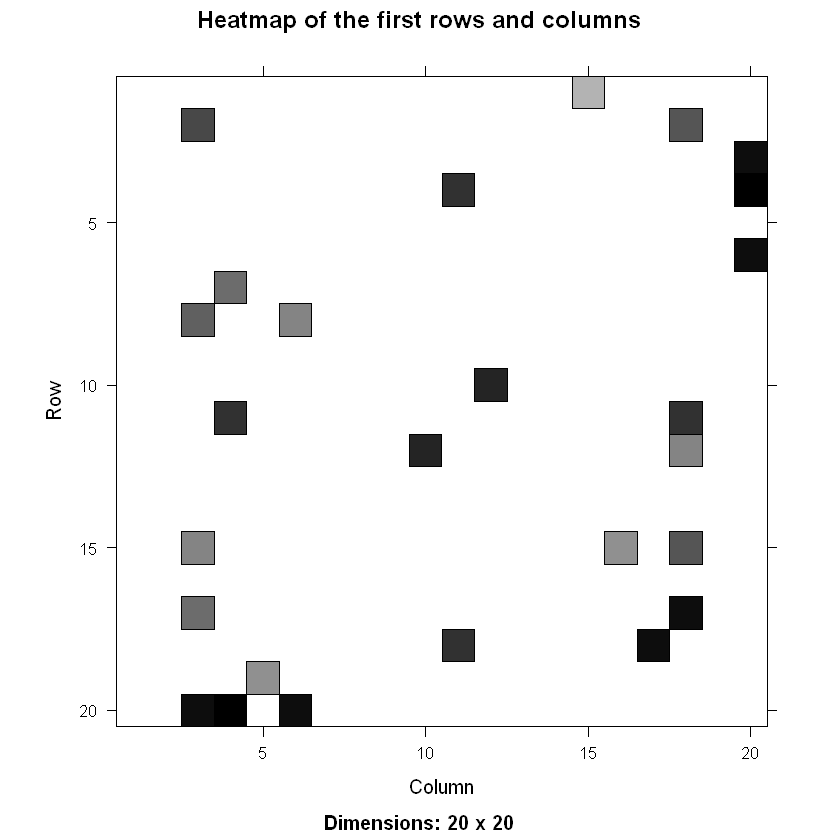

In [29]:
# Exploring the data science recommendation system model
model_info <- getModel(recommen_model)
class(model_info$sim)
dim(model_info$sim)
top_items <- 20
image(model_info$sim[1:top_items, 1:top_items],
      main = "Heatmap of the first rows and columns")

sum_rows
 30 
447 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



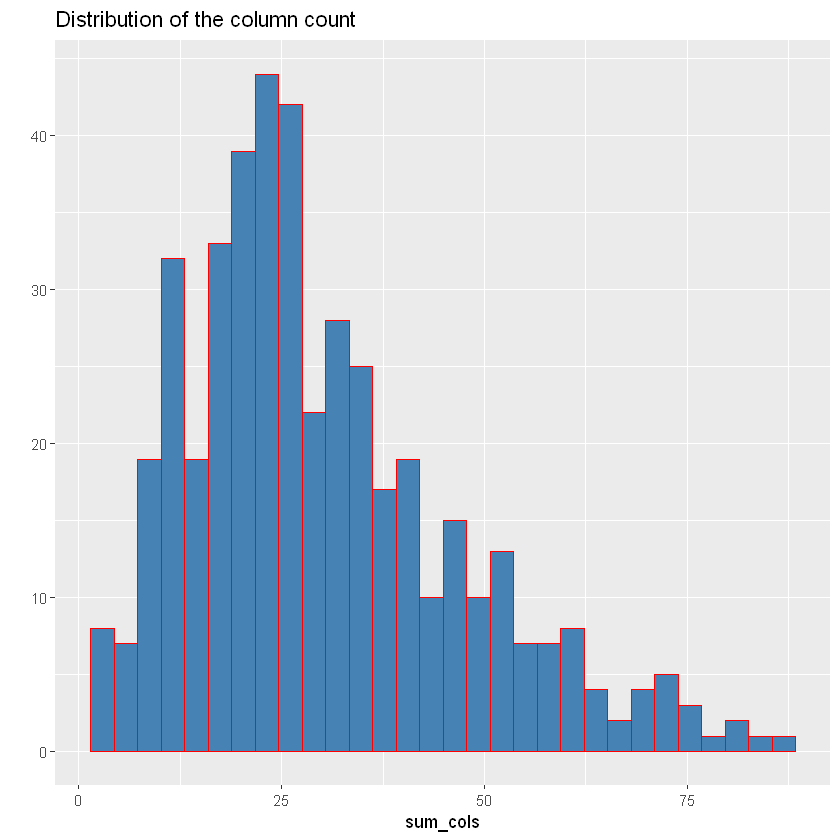

In [30]:
# Visualize sum of rows and columns with the similarity of the objects above 0
sum_rows <- rowSums(model_info$sim > 0)
table(sum_rows)
sum_cols <- colSums(model_info$sim > 0)
qplot(sum_cols, fill=I("steelblue"), col=I("red"))+ ggtitle("Distribution of the column count")

In [31]:
# the number of items to recommend to each user
top_recommendations <- 10 
predicted_recommendations <- predict(object = recommen_model,
                                     newdata = testing_data,
                                     n = top_recommendations)
predicted_recommendations

Recommendations as 'topNList' with n = 10 for 79 users. 

In [32]:
# recommendation for the first user
user1 <- predicted_recommendations@items[[1]] 
movies_user1 <- predicted_recommendations@itemLabels[user1]
movies_user2 <- movies_user1
for (index in 1:10){
  movies_user2[index] <- as.character(subset(movie_data,
                                             movie_data$movieId == movies_user1[index])$title)
}
movies_user2

[1] "Fifth Element, The (1997)"                                                  
 [2] "M*A*S*H (a.k.a. MASH) (1970)"                                               
 [3] "2001: A Space Odyssey (1968)"                                               
 [4] "Wizard of Oz, The (1939)"                                                   
 [5] "Big Lebowski, The (1998)"                                                   
 [6] "Nightmare Before Christmas, The (1993)"                                     
 [7] "Slumdog Millionaire (2008)"                                                 
 [8] "Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)"
 [9] "Rear Window (1954)"                                                         
[10] "Amadeus (1984)"

In [33]:
# matrix with the recommendations for each user
recommendation_matrix <- sapply(predicted_recommendations@items,
                                function(x){ as.integer(colnames(movie_ratings)[x]) }) 

In [34]:
#dim(recc_matrix)
recommendation_matrix[,1:4]

1527,541,356,2078
5060,802,457,2700
924,904,595,2028
919,908,1500,1262
1732,912,1704,3175
551,1079,5418,919
63082,1089,161,3418
750,1094,364,2529
904,1136,3081,3114
1225,1148,1729,589


,Movie Title,No. of Items
,<chr>,<fct>
235,Ed Wood (1994),11
904,Rear Window (1954),10
6,Heat (1995),9
745,Wallace & Gromit: A Close Shave (1995),9


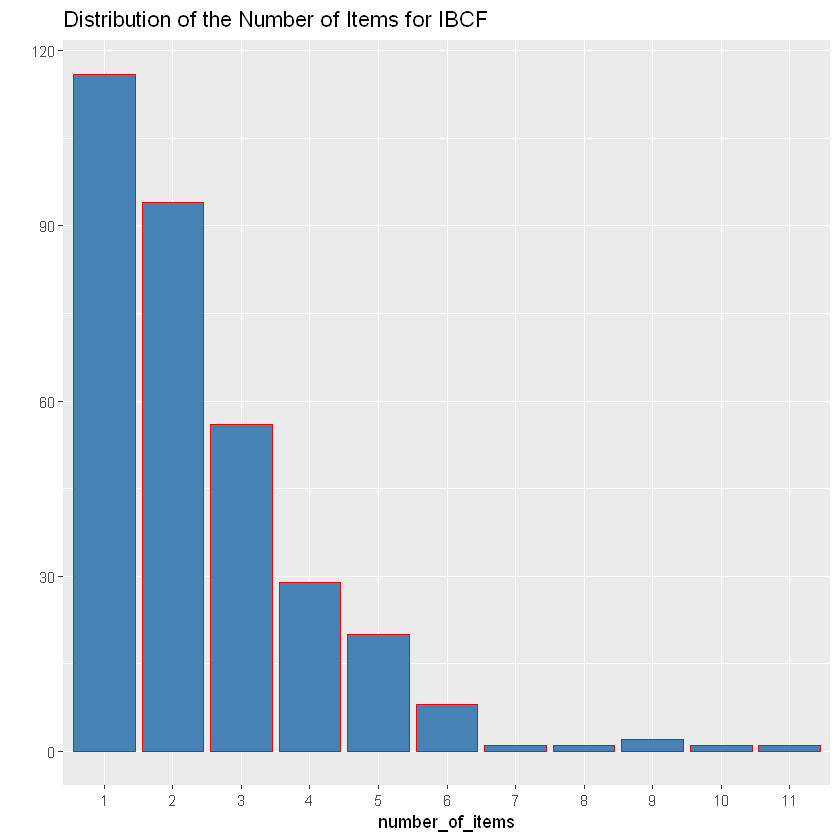

In [35]:
# Distribution of the Number of Items for IBCF
number_of_items <- factor(table(recommendation_matrix))
chart_title <- "Distribution of the Number of Items for IBCF"
qplot(number_of_items, fill=I("steelblue"), col=I("red")) + ggtitle(chart_title)

number_of_items_sorted <- sort(number_of_items, decreasing = TRUE)
number_of_items_top <- head(number_of_items_sorted, n = 4)
table_top <- data.frame(as.integer(names(number_of_items_top)),
                        number_of_items_top)
for(i in 1:4) {
  table_top[i,1] <- as.character(subset(movie_data,
                                        movie_data$movieId == table_top[i,1])$title)
}

colnames(table_top) <- c("Movie Title", "No. of Items")
head(table_top)